<a href="https://colab.research.google.com/github/chandanareddy-enugala/NLP-SLU/blob/main/NMT_Eng_to_Tel_Encoder_Decoder_V05_Attention_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 102 kB/s 


In [3]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 1.7 MB 39.4 MB/s 
     |████████████████████████████████| 6.0 MB 39.5 MB/s 
     |████████████████████████████████| 439 kB 62.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.1

In [4]:
import os
import sys
import random
import time
import re
import numpy as np
import pandas as pd
from typing import Any, Tuple
import nltk

nltk.download('punkt')

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import preprocessing

random.seed(16)
import tensorflow as tf
import tensorflow_text  as tf_text
# from Bio import pairwise2
from functools import partial
from collections import deque
import pathlib

use_builtins = True
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import random
import numpy as np
import nltk
nltk.download('punkt')
import einops
import matplotlib.pyplot as plt
random.seed(16)
import tensorflow as tf
import tensorflow_text  as tf_text
use_builtins = True
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
dataLocation = "/content/drive/MyDrive/nlp/"
fileName = "english_telugu_data.txt"
filePath = dataLocation + fileName
data = []
with open(filePath, mode='rt', encoding='utf-8') as f:
  for line in f.readlines():
    data.append(line)

In [7]:
# ====================================================================================================
# SPLITTING DATA
# ====================================================================================================
# ------------------------------------------------------------------------ SPLIT INPUT & TARGET
def split_data_into_source_target(data, splitString):  # data, "++++$++++"
  print("Separating English & Telugu into differnt variables --->")
  print("========================================================")
  source_eng = []
  target_tel = []
  for line in data:
      line_split = line.split(splitString)
      source_eng.append(line_split[0])
      target_tel.append(line_split[1])
  print("English data is stored @source_eng variable which will be returned")
  print("Telugu data is stored @target_tel variable which will be returned")
  print("\n", " " * 10, "# " * 5, "\n")
  return source_eng, target_tel

input_texts, target_texts = split_data_into_source_target(data, "++++$++++")

input_training_data = input_texts[:100001]
target_training_data = target_texts[:100001]

Separating English & Telugu into differnt variables --->
English data is stored @source_eng variable which will be returned
Telugu data is stored @target_tel variable which will be returned

            # # # # #  



In [8]:
print("input_training_data records  : ", len(input_training_data))
print("target_training_data records : ", len(target_training_data))

input_training_data records  :  100001
target_training_data records :  100001


In [9]:
allwords=[]
for sentence in input_training_data:
  allwords += sentence.split(" ")

In [10]:
len(list(set(allwords)))

22026

In [11]:
input_training_data[10], target_training_data[10]

('He feels very happy.', 'అతను చాలా సంతోషంగా ఉన్నాడు.\n')

**ShapeChecker**

In [12]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
        return
    parsed = einops.parse_shape(tensor, names)

    for name, newDim in parsed.items():
        oldDim = self.shapes.get(name, None)
        if (broadcast and newDim == 1):
            continue
        if oldDim is None:
            # It adds the axis length to the cache, if the axis name is new.
            self.shapes[name] = newDim
            continue
        if newDim != oldDim:
            raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                              f"    found: {newDim}\n"
                              f"    expected: {oldDim}\n")

**Uniform Distribution data Creation**

In [ ]:
len(input_training_data_ud),len(target_training_data_ud),len(input_validation_data_ud),len(target_validation_data_ud)

(79990, 79990, 20011, 20011)

In [13]:
SOURCE_TRAINING_DATA_SIZE = len(input_training_data)
BATCH_SIZE = 32

is_train_ud = np.random.uniform(size=(len(target_training_data),)) < 0.8

input_training_data_ud=[]
target_training_data_ud=[]
input_validation_data_ud=[]
target_validation_data_ud=[]
training_indexes=[i for i,bl in enumerate(is_train_ud)  if bl==True]
validation_indexes=[i for i,bl in enumerate(is_train_ud)  if bl!=True]
for i in training_indexes:
    input_training_data_ud.append(input_training_data[i])
    target_training_data_ud.append(target_training_data[i])
for i in validation_indexes:
    input_validation_data_ud.append(input_training_data[i])
    target_validation_data_ud.append(target_training_data[i])


In [14]:
len(input_training_data_ud),len(target_training_data_ud),len(input_validation_data_ud),len(target_validation_data_ud)

(80001, 80001, 20000, 20000)

In [15]:
# ================================================================================================================================================
# ================================================================================================================================================
training_batchData = (tf.data.Dataset
                      .from_tensor_slices((input_training_data_ud,target_training_data_ud ))
                      .shuffle(SOURCE_TRAINING_DATA_SIZE)
                      .batch(BATCH_SIZE)
                      )

validation_batchData = (tf.data.Dataset
                        .from_tensor_slices((input_validation_data_ud, target_validation_data_ud))
                        .shuffle(SOURCE_TRAINING_DATA_SIZE)
                        .batch(BATCH_SIZE)
                        )

for input_strings, target_strings in training_batchData.take(1):
    print(input_strings[:10])
    print("=======================================")
    print(target_strings[:10])
    break


tf.Tensor(
[b'Do you know whose car that is?'
 b"It won't take me much time to do that." b"That's why I'm here."
 b'Tell me that was a joke!' b"Tom shouldn't have made Mary angry."
 b"I'll do that no matter what you say." b"I say it's worth a try."
 b'I want to get rich quickly.'
 b"It's going to take time to get that done."
 b'There are quite a few hotels by the lake.'], shape=(10,), dtype=string)
tf.Tensor(
[b'\xe0\xb0\x85\xe0\xb0\xa6\xe0\xb0\xbf \xe0\xb0\x8e\xe0\xb0\xb5\xe0\xb0\xb0\xe0\xb0\xbf \xe0\xb0\x95\xe0\xb0\xbe\xe0\xb0\xb0\xe0\xb1\x81 \xe0\xb0\x85\xe0\xb0\xa8\xe0\xb0\xbf \xe0\xb0\xae\xe0\xb1\x80\xe0\xb0\x95\xe0\xb1\x81 \xe0\xb0\xa4\xe0\xb1\x86\xe0\xb0\xb2\xe0\xb1\x81\xe0\xb0\xb8\xe0\xb0\xbe?\n'
 b'\xe0\xb0\x85\xe0\xb0\xb2\xe0\xb0\xbe \xe0\xb0\x9a\xe0\xb1\x87\xe0\xb0\xaf\xe0\xb0\xa1\xe0\xb0\xbe\xe0\xb0\xa8\xe0\xb0\xbf\xe0\xb0\x95\xe0\xb0\xbf \xe0\xb0\xa8\xe0\xb0\xbe\xe0\xb0\x95\xe0\xb1\x81 \xe0\xb0\x8e\xe0\xb0\x95\xe0\xb1\x8d\xe0\xb0\x95\xe0\xb1\x81\xe0\xb0\xb5 \xe0\xb0\xb8\xe

**Standardization**

**Normalization, Lower, Strip**

In [16]:
# ================================================================================================================================================
# Unicode normalization
# ================================================================================================================================================
def text_normalize_lower_strip(sentence):
    # Split accented characters.
    sentence = tf_text.normalize_utf8(sentence, 'NFKD')
    #lowering all the letters
    sentence = tf.strings.lower(sentence)
    #removing spaces from the starting and end
    sentence = tf.strings.strip(sentence)
    #add([START] in the beginning and [END] in the ending)
    sentence = tf.strings.join(['[START]', sentence, '[END]'], separator=' ')
    return sentence

In [17]:
#validating the above function
example_text = tf.constant('vaLidating The aBove function. ')
print(example_text.numpy().decode())
print(text_normalize_lower_strip(example_text).numpy().decode())

vaLidating The aBove function. 
[START] validating the above function. [END]


**Text Vectorization**

In [19]:

# ================================================================================================================================================
# Text Vectorization
# ================================================================================================================================================
max_vocab_size = 12000
input_text_preprocessor = tf.keras.layers.TextVectorization(standardize=text_normalize_lower_strip,
                                                            max_tokens=max_vocab_size,
                                                            ragged=True)

input_text_preprocessor.adapt(training_batchData.map(lambda context, target: context))
# Here are the first 10 words from the vocabulary:
print(input_text_preprocessor.get_vocabulary()[:10])

target_text_preprocessor = tf.keras.layers.TextVectorization(standardize=text_normalize_lower_strip,
                                                             max_tokens=max_vocab_size,
                                                             ragged=True)

target_text_preprocessor.adapt(training_batchData.map(lambda context, target: target))
print(target_text_preprocessor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', 'tom', 'i', 'to', 'the', 'you', 'a']
['', '[UNK]', '[START]', '[END]', 'టామ్', 'నేను', 'మీరు', 'నాకు', 'చాలా', 'నా']


**Layers -> Text -> Token ID**

In [20]:
# ================================================================================================================================================
# Layers can convert a batch of strings into a batch of token IDs
# ================================================================================================================================================
# CHECK : NO_USE -----------------------------
example_tokens = input_text_preprocessor(input_strings)
print(example_tokens[:3, :])

<tf.RaggedTensor [[2, 13, 8, 24, 827, 240, 11, 934, 3],
 [2, 26, 108, 111, 28, 123, 99, 6, 13, 47, 3], [2, 98, 55, 27, 102, 3]]>


**Layers -> Token ID -> Text**

In [21]:
# ================================================================================================================================================
# The get_vocabulary method can be used to convert token IDs back to text:
# ================================================================================================================================================
# CHECK : NO_USE -----------------------------
context_vocab = np.array(input_text_preprocessor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
print(' '.join(tokens))

[START] do you know whose car that is? [END]


In [22]:
def preprocess_data(input, target):
    input = input_text_preprocessor(input).to_tensor()
    target = target_text_preprocessor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (input, targ_in), targ_out

training_preprocess_data = training_batchData.map(preprocess_data, tf.data.AUTOTUNE)
validation_preprocess_data = validation_batchData.map(preprocess_data, tf.data.AUTOTUNE)

In [23]:
# CHECK : Print -----------------------------
for (input_string2, target_string2), ex_tar_out in training_preprocess_data.take(1):
    print(input_string2[0, :10].numpy())
    print()
    print(target_string2[0, :10].numpy())
    print(ex_tar_out[0, :10].numpy())

[   2  994   10   76   16    7  200 9299   16 4485]

[   2 4257   71   51    1 1725  937    0    0    0]
[4257   71   51    1 1725  937    3    0    0    0]


**Encoder Architecture**

In [24]:
# ================================================================================================================================================
# Encoder Architecture
# ================================================================================================================================================
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units,
                                                   mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(merge_mode='sum',
                                                 layer=tf.keras.layers.GRU(units,
                                                                           return_sequences=True,
                                                                           recurrent_initializer='glorot_uniform')
                                                 )
    def call(self, input):
        shape_checker = ShapeChecker()
        shape_checker(input, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        input = self.embedding(input)
        shape_checker(input, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        input = self.rnn(input)
        shape_checker(input, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return input

    def convert_input(self, input_texts):
        input_texts = tf.convert_to_tensor(input_texts)
        if len(input_texts.shape) == 0:
            input_texts = tf.convert_to_tensor(input_texts)[tf.newaxis]
        input_tensor = self.text_processor(input_texts).to_tensor()
        input_tensor = self(input_tensor)
        return input_tensor


In [25]:
UNITS = 128
# Encode the input sequence.
encoder = Encoder(input_text_preprocessor, UNITS)
ex_context = encoder(input_string2)

In [26]:
# CHECK : Print -----------------------------
print(f'Input tokens, shape (batch, s): {input_string2.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Input tokens, shape (batch, s): (32, 17)
Encoder output, shape (batch, s, units): (32, 17, 128)


**Attention Layer**

In [27]:
# ================================================================================================================================================
# The attention layer
# ================================================================================================================================================
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, X, context):
        shape_checker = ShapeChecker()

        shape_checker(X, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=X,
            value=context,
            return_attention_scores=True)

        shape_checker(X, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        X = self.add([X, attn_output])
        X = self.layernorm(X)

        return X

In [28]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_preprocessor.vocabulary_size(),
                                  output_dim=UNITS,
                                  mask_zero=True)
ex_target_embed = embed(target_string2)

result = attention_layer(ex_target_embed, ex_context)

print(f'Input sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_target_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Input sequence, shape (batch, s, units): (32, 17, 128)
Target sequence, shape (batch, t, units): (32, 11, 128)
Attention result, shape (batch, t, units): (32, 11, 128)
Attention weights, shape (batch, t, s):    (32, 11, 17)


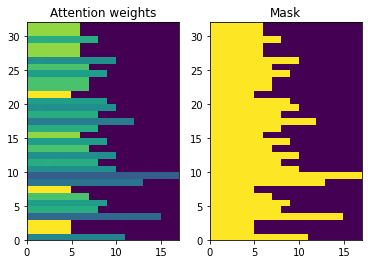

In [29]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

# Plot Graph -------------------------
attention_weights = attention_layer.last_attention_weights
mask=(input_string2 != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

**Decoder Architecture**

In [30]:
# ================================================================================================================================================
# Decoder architecture
# ================================================================================================================================================
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_index = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                                          mask_token='', oov_token='[UNK]'
                                                          )
        self.index_to_word = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                                          mask_token='', oov_token='[UNK]',
                                                          invert=True
                                                          )
        self.start_token = self.word_to_index('[START]')
        self.end_token = self.word_to_index('[END]')

        self.units = units

        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [31]:
@Decoder.add_method
def call(self, context, X, state=None, return_state=False):
    shape_checker = ShapeChecker()
    shape_checker(X, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    X = self.embedding(X)
    shape_checker(X, 'batch t units')

    # 2. Process the target sequence.
    X, state = self.rnn(X, initial_state=state)
    shape_checker(X, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    X = self.attention(X, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(X, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(X)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [32]:
decoder = Decoder(target_text_preprocessor, UNITS)

logits = decoder(ex_context, target_string2)
print(f'encoder output shape      : (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape : (batch, t) {target_string2.shape}')
print(f'logits shape shape        : (batch, target_vocabulary_size) {logits.shape}')

encoder output shape      : (batch, s, units) (32, 17, 128)
input target tokens shape : (batch, t) (32, 11)
logits shape shape        : (batch, target_vocabulary_size) (32, 11, 12000)


**Inferene Stage**

In [33]:
# ================================================================================================================================================
# Inference
# ================================================================================================================================================
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.index_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '[START]', '')
    result = tf.strings.regex_replace(result, '[END]', '')
    return result


@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature=0.0):
    logits, state = self(context, next_token,
                         state=state,
                         return_state=True
                         )

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :] / temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state


In [34]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'\xe0\xb0\xb5\xe0\xb0\xb9\xe0\xb0\xbf\xe0\xb0\x82\xe0\xb0\x9a\xe0\xb0\xbe\xe0\xb0\xa8\xe0\xb1\x81. \xe0\xb0\x95\xe0\xb0\xa8\xe0\xb1\x81\xe0\xb0\x97\xe0\xb1\x8a\xe0\xb0\xa8\xe0\xb1\x8d\xe0\xb0\xa8\xe0\xb0\xbe\xe0\xb0\xa1\xe0\xb1\x81. \xe0\xb0\x9a\xe0\xb1\x86\xe0\xb0\x82\xe0\xb0\xa6\xe0\xb0\xbf\xe0\xb0\xa8 \xe0\xb0\xa4\xe0\xb0\xa1\xe0\xb0\xbf\xe0\xb0\xb8\xe0\xb0\xbf\xe0\xb0\xaa\xe0\xb1\x8b\xe0\xb0\xaf\xe0\xb0\xbe\xe0\xb0\xaf\xe0\xb0\xbf. \xe0\xb0\xa8\xe0\xb0\x97\xe0\xb1\x8d\xe0\xb0\xa8\xe0\xb0\x82\xe0\xb0\x97\xe0\xb0\xbe \xe0\xb0\xaa\xe0\xb0\x9a\xe0\xb1\x8d\xe0\xb0\x9a\xe0\xb0\xbf\xe0\xb0\x95 \xe0\xb0\xb5\xe0\xb1\x86\xe0\xb0\xa4\xe0\xb0\x95\xe0\xb0\x82\xe0\xb0\xa1\xe0\xb0\xbf. \xe0\xb0\xae\xe0\xb1\x81\xe0\xb0\x97\xe0\xb0\xbf\xe0\xb0\xb8\xe0\xb0\xbf\xe0\xb0\x82\xe0\xb0\xa6\xe0\xb0\xbf? \xe0\xb0\xb7\xe0\xb0\xbe\xe0\xb0\xaa\xe0\xb0\xbf\xe0\xb0\x82\xe0\xb0\x97\xe0\xb1\x8d\xe2\x80\x8c\xe0\xb0\x95\xe0\xb1\x81 \xe0\xb0\x87\xe0\xb0\xb0\xe0\xb0\xbe\xe0\xb0\x95\xe0\xb1\x8d',
       b'\xe0\

Code ReferenceTaken from :
https://www.tensorflow.org/text/tutorials/nmt_with_attention


**Model Prepartion: Translator**

In [35]:
# ================================================================================================================================================
# Model
# ================================================================================================================================================
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units, context_text_processor, target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy.
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [36]:
model = Translator(UNITS, input_text_preprocessor, target_text_preprocessor)

logits = model((input_string2, target_string2))

print(f'Input tokens, shape  : (batch, s, units) {input_string2.shape}')
print(f'Target tokens, shape : (batch, t) {target_string2.shape}')
print(f'       logits, shape : (batch, t, target_vocabulary_size) {logits.shape}')

Input tokens, shape  : (batch, s, units) (32, 17)
Target tokens, shape : (batch, t) (32, 11)
       logits, shape : (batch, t, target_vocabulary_size) (32, 11, 12000)


**Model Training**

In [37]:
# ================================================================================================================================================
# Training
# ================================================================================================================================================
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


def masked_accuracy(Y_actual, Y_pred):
    # Calculate the loss for each item in the batch.
    Y_pred = tf.argmax(Y_pred, axis=-1)
    Y_pred = tf.cast(Y_pred, Y_actual.dtype)

    match_records = tf.cast(Y_actual == Y_pred, tf.float32)
    mask_value = tf.cast(Y_actual != 0, tf.float32)

    return tf.reduce_sum(match_records) / tf.reduce_sum(mask_value)

In [38]:
model.compile(optimizer='adam',  #adam
              loss=masked_loss,
              metrics=[masked_accuracy, masked_loss])

vocab_size = 1.0 * target_text_preprocessor.vocabulary_size()

print({"expected_loss": tf.math.log(vocab_size).numpy(), "expected_acc": 1 / vocab_size})

model.evaluate(validation_preprocess_data, steps=20, return_dict=True)

{'expected_loss': 9.392662, 'expected_acc': 8.333333333333333e-05}
20/20 [==============================] - 24s 251ms/step - loss: 9.3976 - masked_accuracy: 0.0000e+00 - masked_loss: 9.3976


{'loss': 9.397582054138184,
 'masked_accuracy': 0.0,
 'masked_loss': 9.397582054138184}

In [39]:
history = model.fit(training_preprocess_data.repeat(),
                    epochs=100,
                    steps_per_epoch = 100,
                    validation_data=validation_preprocess_data,
                    validation_steps = 20,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
                    )

Epoch 1/100
100/100 [==============================] - 58s 381ms/step - loss: 6.5962 - masked_accuracy: 0.2036 - masked_loss: 6.5962 - val_loss: 5.6764 - val_masked_accuracy: 0.2514 - val_masked_loss: 5.6764
Epoch 2/100
100/100 [==============================] - 40s 402ms/step - loss: 5.5331 - masked_accuracy: 0.2813 - masked_loss: 5.5331 - val_loss: 5.0938 - val_masked_accuracy: 0.3250 - val_masked_loss: 5.0938
Epoch 3/100
100/100 [==============================] - 40s 403ms/step - loss: 5.1127 - masked_accuracy: 0.3225 - masked_loss: 5.1127 - val_loss: 4.8428 - val_masked_accuracy: 0.3498 - val_masked_loss: 4.8428
Epoch 4/100
100/100 [==============================] - 40s 397ms/step - loss: 4.8481 - masked_accuracy: 0.3460 - masked_loss: 4.8481 - val_loss: 4.5702 - val_masked_accuracy: 0.3782 - val_masked_loss: 4.5702
Epoch 5/100
100/100 [==============================] - 40s 399ms/step - loss: 4.5574 - masked_accuracy: 0.3825 - masked_loss: 4.5574 - val_loss: 4.2367 - val_masked_acc

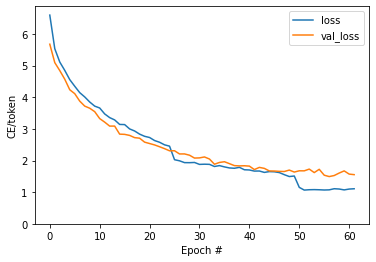

In [40]:
# Plot Graph -----------------------------------
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

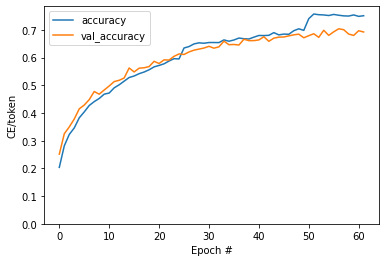

In [41]:

# Plot Graph -----------------------------------
plt.plot(history.history['masked_accuracy'], label='accuracy')
plt.plot(history.history['val_masked_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [42]:
history.history.keys()

dict_keys(['loss', 'masked_accuracy', 'masked_loss', 'val_loss', 'val_masked_accuracy', 'val_masked_loss'])

**Save Model**

In [43]:
# Saving Model -----------------------------------
model.save(dataLocation+'NLP_Eng_to_Tel_Encoder_Decoder_V05_attention_model')

**Model Prediction**

In [44]:
# @title
@Translator.add_method
def translate(self, texts, *,max_length=50, temperature=0.0):
    # Encoding : PreProcess the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Inference Stage : Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    # Decoding: 
    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done, state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)  # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

**Model Testing**

In [58]:
# ================================================================================================================================================
# Testing
# ================================================================================================================================================
test_source = input_texts[100001:]
test_target = target_texts[100001:]

print(test_source[159])
print(test_target[159])
print(len(test_source))

I don't know why Tom didn't come.
టామ్ ఎందుకు రాలేదో నాకు తెలియదు.

55797


In [47]:
len(test_source)

55797

**BleuScore**

In [56]:
##bleuscore for 10000 records of test data
from datetime import datetime
startTime=datetime.now()
actualEngData = []
actualTelData = []
predTelData = []
bleuScore=0
n=10000
for i in range(n):
    actualEngData.append(test_source[i])
    actualTelData.append(test_target[i])
    predTelData.append(model.translate([test_source[i]])[0].numpy().decode())
for i in range(n):
  #predTelData.append(model.translate([actualEngData[i]])[0].numpy().decode())
  bleuScore += nltk.translate.bleu_score.sentence_bleu(actualTelData[i], predTelData[i],weights=[1]) #weights=[4]
total_bleuscore =bleuScore/n
endTime=datetime.now()
print(f"number of test records:{n};bleuSCore:{total_bleuscore}")
endTime=endTime-startTime
print("code running time",endTime)


number of test records:10000;bleuSCore:0.4807346976265426
code running time 2022-12-10 05:41:44.585863


In [57]:
#displaying the predictions
startTime=datetime.now()
bleuScore=0
n=15
for i in range(n):
    print("english_source",actualEngData[i])
    print("actual_telugu",actualTelData[i])
    print("predTelData",predTelData[i])
    print("==========================")
    bleuScore += nltk.translate.bleu_score.sentence_bleu(actualTelData[i], predTelData[i],weights=[1])
total_bleuscore =bleuScore/n
endTime=datetime.now()
print(f"number of test records:{n};bleuSCore:{total_bleuscore}")
print("code running time",endTime)

english_source When I was a child, I believed in Santa Claus.
actual_telugu నేను చిన్నతనంలో, శాంతా క్లాజ్‌ను నమ్మాను.

predTelData నేను చిన్నతనంలో, నేను వయోలిన్ [UK] 
english_source Don't you know her name?
actual_telugu ఆమె పేరు మీకు తెలియదా?

predTelData ఆమె పేరు మీకు తెలుసా? 
english_source Tom brought Mary to our party.
actual_telugu టామ్ మేరీని మా పార్టీకి తీసుకువచ్చాడు.

predTelData టామ్ మేరీ మా పార్టీకి తెచ్చాడు. 
english_source I'm sorry. I forgot about this.
actual_telugu నన్ను క్షమించండి.

predTelData నేను క్షమించండి, నేను దీని గురించి మర్చిపోయాను. 
english_source If I weren't poor, I'd buy that car.
actual_telugu నేను పేదవాడు కాకపోతే, నేను ఆ కారు కొంటాను.

predTelData నేను ఆ [UK] [UK] సమాధానం కొంటాను. 
english_source Tom is afraid of big dogs.
actual_telugu టామ్ పెద్ద కుక్కలకు భయపడతాడు.

predTelData టామ్ పెద్ద కుక్కలకు భయపడతాడు. 
english_source That guy is a party pooper.
actual_telugu ఆ వ్యక్తి పార్టీ పూపర్.

predTelData ఆ వ్యక్తి పార్టీ [UK] 
english_source You're going to

In [55]:

result = model.translate(["Don't you know her name?"]) # Are you still home
result[0].numpy().decode()
     

'ఆమె పేరు మీకు తెలుసా? '

In [ ]:
with open(dataLocation + 'test_source.txt', 'wb') as file:
    pickle.dump(test_source, file)
with open(dataLocation + 'test_target.txt', 'wb') as file:
    pickle.dump(test_target, file)

In [ ]:
#bleuscore for 1000 records of test data
def evaluate(actualEngData,actualTelData,n=1000):
  predTelData=[]
  bleuScore=0
  for i in range(n):
    predTelData.append(model.translate([actualEngData[i]])[0].numpy().decode())
    bleuScore += nltk.translate.bleu_score.sentence_bleu(actualTelData[i], predTelData[i],weights=[1]) #weights=[4]
  total_bleuscore=bleuScore/n
  result={"actualEngData":actualEngData[0:n],
          "actualTelData":actualTelData[0:n],
          "predTelData":predTelData[0:n],
          "bleuScore":total_bleuscore}
  return result
  

In [ ]:
result = evaluate(test_source,test_target,n=1000)
"""print(result["actualEngData"][0])
print(result["actualTelData"][0])
print(result["predTelData"][0])"""
print(result["bleuScore"])


0.43179537269719415


In [ ]:
"""import pickle
with open(dataLocation+'Bleu_Score_With_Attention', 'wb') as file:
  pickle.dump(blueScore, file)"""

In [ ]:
with open(dataLocation + 'test_source.txt', 'wb') as file:
    pickle.dump(test_source, file)
with open(dataLocation + 'test_target.txt', 'wb') as file:
    pickle.dump(test_target, file)